In [31]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx

from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *


# sns style white
sns.set_style("whitegrid")


In [32]:

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:

PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')



In [34]:

df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
METRIC = "I(X_1->X_2)/d_2"

table = make_table_pivot(METRIC, df)


In [35]:


METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)', 'Reranking Average (4 datasets)']

mteb = pd.read_csv('exported_data/df_mteb_avg.csv')

import re

def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]

mteb['model'] = mteb['Model'].apply(extract_url_from_html_link).apply(lambda x: "/".join(x.split('/')[-2:]))

avg_results = table.median(axis=0).sort_values(ascending=False).to_frame().reset_index().rename(columns={0: METRIC, 'model_1': 'model'}).merge(mteb, on='model', how='left').sort_values(METRIC, ascending=False)

# make model shorter
avg_results['model'] = avg_results['model'].apply(lambda x: x.split('/')[-1])




In [36]:

avg_results


,model,I(X_1->X_2)/d_2,Rank,Model,Model Size (Million Parameters),"Memory Usage (GB, fp32)",Embedding Dimensions,Max Tokens,Average (56 datasets),Classification Average (12 datasets),Clustering Average (11 datasets),PairClassification Average (3 datasets),Reranking Average (4 datasets),Retrieval Average (15 datasets),STS Average (10 datasets),Summarization Average (1 datasets)
0,SFR-Embedding-Mistral,0.585374,2.0,"<a target=""_blank"" style=""text-decoration: und...",7111.0,26.49,4096.0,32768.0,67.56,78.33,51.67,88.54,60.64,59.00,85.05,31.16
1,echo-mistral-7b-instruct-lasttoken,0.580668,12.0,"<a target=""_blank"" style=""text-decoration: und...",7111.0,26.49,4096.0,32768.0,64.68,77.43,46.32,87.34,58.14,55.52,82.56,30.73
2,stella-base-en-v2,0.571641,33.0,"<a target=""_blank"" style=""text-decoration: und...",55.0,0.20,768.0,512.0,62.61,75.28,44.90,86.45,58.78,50.10,83.02,32.52
3,e5-large-v2,0.569240,38.0,"<a target=""_blank"" style=""text-decoration: und...",335.0,1.25,1024.0,512.0,62.25,75.24,44.49,86.03,56.61,50.56,82.05,30.19
4,GritLM-7B,0.563432,5.0,"<a target=""_blank"" style=""text-decoration: und...",7242.0,26.98,4096.0,32768.0,66.76,79.46,50.61,87.16,60.49,57.41,83.35,30.37
5,ember-v1,0.558387,27.0,"<a target=""_blank"" style=""text-decoration: und...",335.0,1.25,1024.0,512.0,63.54,75.99,45.58,87.37,60.04,51.92,83.34,30.82
6,gte-large,0.557618,30.0,"<a target=""_blank"" style=""text-decoration: und...",335.0,1.25,1024.0,512.0,63.13,73.33,46.84,85.00,59.13,52.22,83.35,31.66
7,UAE-Large-V1,0.554182,14.0,"<a target=""_blank"" style=""text-decoration: und...",335.0,1.25,1024.0,512.0,64.64,75.58,46.73,87.25,59.88,54.66,84.54,32.03
8,gte-base,0.552839,34.0,"<a target=""_blank"" style=""text-decoration: und...",109.0,0.41,768.0,512.0,62.39,73.01,46.20,84.57,58.61,51.14,82.30,31.17
9,sf_model_e5,0.552193,28.0,"<a target=""_blank"" style=""text-decoration: und...",335.0,1.25,1024.0,512.0,63.34,73.96,46.61,86.85,59.86,51.80,83.85,31.61


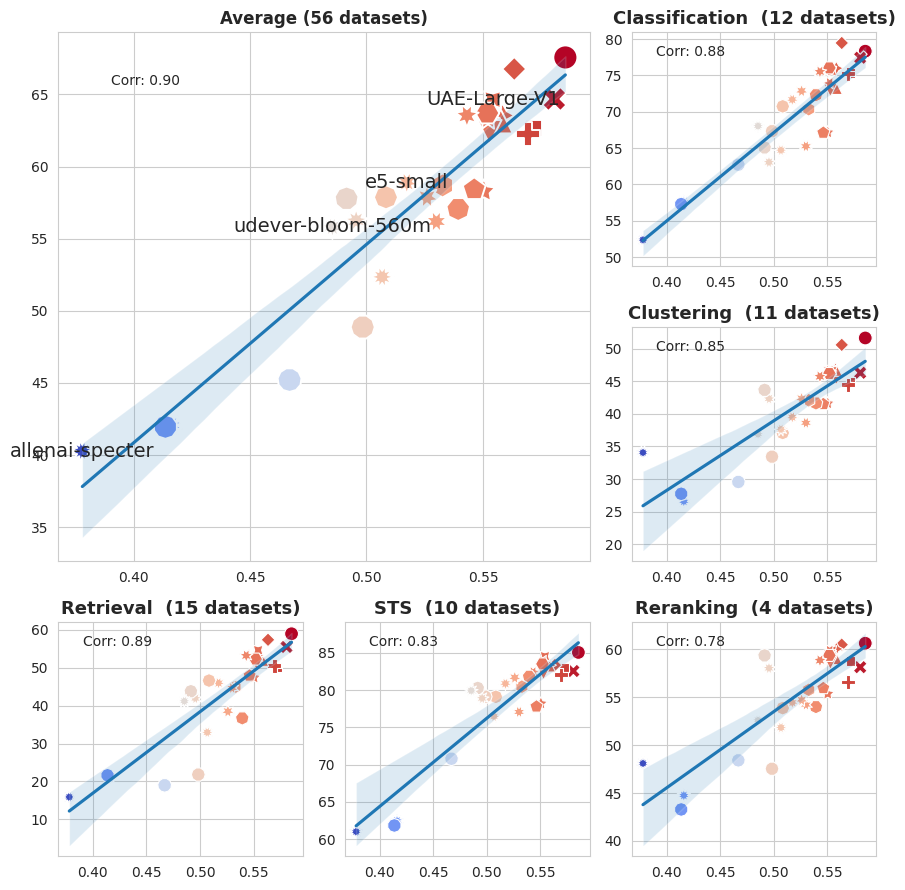

In [37]:
# make mosaic map

mosaic_map = [
    ['A', 'A', 'B'],
    ['A', 'A', 'C'],
    ['D', 'E', 'F'],
              ]

mosaic_to_task_map = {
    'A': 'Average (56 datasets)',
    'B': 'Classification Average (12 datasets)',
    'C': 'Clustering Average (11 datasets)',
    'D': 'Retrieval Average (15 datasets)',
    'E': 'STS Average (10 datasets)',
    'F': 'Reranking Average (4 datasets)',
}

mosaic_map = np.array(mosaic_map)
mosaic_map = np.vectorize(lambda x: mosaic_to_task_map[x])(mosaic_map)

MODEL_TO_ANNOATE = set(["UAE-Large-V1", "allenai-specter", "e5-small",  "udever-bloom-560m",])

fig, ax = plt.subplot_mosaic(mosaic_map, figsize=(9, 9))

for i, metric in enumerate(METRICS):
    if metric == "Average (56 datasets)":
        s = 300
    else:
        s = 100
    
    ax[metric] = sns.scatterplot(data=avg_results, x=METRIC, y=metric, ax=ax[metric], legend=False, hue = METRIC, style='model', s=s, palette="coolwarm")
    ax[metric] = sns.regplot(data=avg_results, x=METRIC, y=metric, ax=ax[metric], scatter=False)
    
    # annotate model names
    if metric == "Average (56 datasets)":
        for i, row in avg_results.iterrows():
           if row['model'] in MODEL_TO_ANNOATE: 
               ax[metric].annotate(row['model'], (row[METRIC], row[metric]), fontsize=14,  va='center', ha='center')
                
    
    # annotate correllation
    corr = avg_results[[METRIC, metric]].corr(method="spearman").iloc[0, 1]
    ax[metric].annotate(f"Corr: {corr:.2f}", (0.1, 0.9), xycoords='axes fraction')
    
    if metric == 'Average (56 datasets)':
        ax[metric].set_title(metric, fontsize=12, fontweight='bold')
    else:
        ax[metric].set_title(metric.replace('Average', ''), fontsize=13, fontweight='bold')
    ax[metric].set_xlabel('')
    ax[metric].set_ylabel('')
    

fig.tight_layout()

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_scatterplot_mtebs_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')


/tmp/ipykernel_339509/692556213.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[metric].annotate(row['model'], (row[metric], row[METRIC]), textcoords='offset points', xytext=xytext, fontsize=8,  va='center', ha='center',


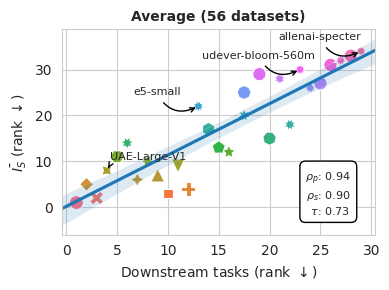

In [38]:


# replace all metric by their rank
ranked_results = avg_results.copy()
for metric in METRICS:
    ranked_results[metric] = avg_results[metric].rank(ascending=False)

ranked_results[METRIC] = avg_results[METRIC].rank(ascending=False)

mosaic_map = [
['A']
]

mosaic_to_task_map = {
    'A': 'Average (56 datasets)',
    'B': 'Classification Average (12 datasets)',
    'C': 'Clustering Average (11 datasets)',
    'D': 'Retrieval Average (15 datasets)',
    'E': 'STS Average (10 datasets)',
    'F': 'Reranking Average (4 datasets)',
}

sns.set_style("whitegrid")

mosaic_map = np.array(mosaic_map)
mosaic_map = np.vectorize(lambda x: mosaic_to_task_map[x])(mosaic_map)

MODEL_TO_ANNOATE = set(["UAE-Large-V1", "allenai-specter", "e5-small",  "udever-bloom-560m",])

fig, ax = plt.subplot_mosaic(mosaic_map, figsize=(4, 3))

metric = 'Average (56 datasets)'

ax[metric] = sns.scatterplot(data=ranked_results, y=METRIC, x=metric, ax=ax[metric], legend=False, hue = 'model', style='model', s=s)
ax[metric] = sns.regplot(data=ranked_results, y=METRIC, x=metric, ax=ax[metric], scatter=False, truncate=False)

# annotate model names
if metric == "Average (56 datasets)":
    for i, row in ranked_results.iterrows():
        if row['model'] in MODEL_TO_ANNOATE:
            if row[METRIC] <= 15:
                xytext = (30, 10)
            else:
                xytext = (-30, 10)
            ax[metric].annotate(row['model'], (row[metric], row[METRIC]), textcoords='offset points', xytext=xytext, fontsize=8,  va='center', ha='center',
                                arrowprops=dict(facecolor='black', color='black', arrowstyle='->', connectionstyle='arc3,rad=0.5'))


# annotate correllation

# annotate with spearmann correlation
spearmann = avg_results[[METRIC, metric]].corr('spearman').loc[[METRIC, metric]].iloc[0, 1]
pearson = avg_results[[METRIC, metric]].corr('pearson').loc[[METRIC, metric]].iloc[0, 1]
kendall = avg_results[[METRIC, metric]].corr('kendall').loc[[METRIC, metric]].iloc[0, 1]

# ax.annotate(f"Spearmann correlation: {corr:.2f}", (0.8, 0.1), xycoords='axes fraction', ha='center', va='center')
ax[metric].annotate(f"$\\rho_p$: {pearson:.2f}\n$\\rho_s$: {spearmann:.2f}\n $\\tau$: {kendall:.2f}", (0.85, 0.2), xycoords='axes fraction', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=8)

if metric == 'Average (56 datasets)':
    ax[metric].set_title(metric, fontsize=10, fontweight='bold')
else:
    ax[metric].set_title(metric.replace('Average', ''), fontsize=10, fontweight='bold')

ax[metric].set_xlabel('Downstream tasks (rank $\\downarrow$)', fontsize=10)
ax[metric].set_ylabel('$\\bar{I_{S}}$ (rank $\\downarrow$)', fontsize=10)

#ax[metric].set_xlim(0.45, 0.6)
# ax[metric].set_ylim(50, 70)


fig.tight_layout()

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_average_scatterplot_mtebs_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')


/tmp/ipykernel_339509/250323228.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_ranking, y='model', x=METRIC, ax=ax[0], palette="coolwarm_r")
/tmp/ipykernel_339509/250323228.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_ranking, y='model', x='Average (56 datasets)', ax=ax[1], palette="coolwarm_r")
/tmp/ipykernel_339509/250323228.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=20, fontweight='bold')
/tmp/ipykernel_339509/250323228.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made l

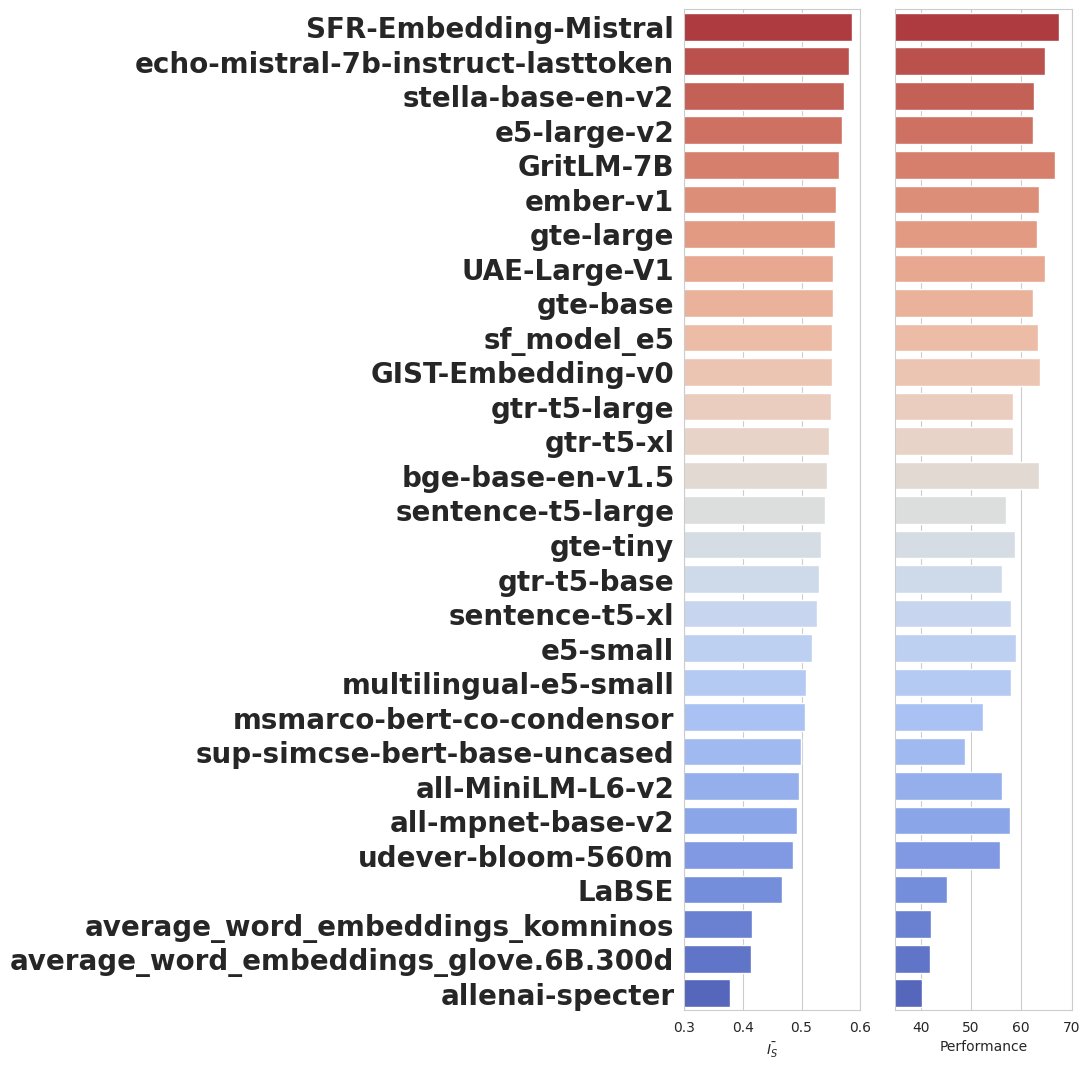

In [39]:

bar_ranking = avg_results[['model', METRIC, 'Average (56 datasets)']].dropna()
bar_ranking['Informativeness Rank'] = bar_ranking[METRIC].rank(ascending=False)
bar_ranking['Performance Rank'] = bar_ranking['Average (56 datasets)'].rank(ascending=False)

bar_ranking = bar_ranking.sort_values('Informativeness Rank')

fig, ax = plt.subplots(ncols=2, figsize=(5, 13), sharey=True)

# horizontal barplot
sns.barplot(data=bar_ranking, y='model', x=METRIC, ax=ax[0], palette="coolwarm_r")
ax[0].set_xlim(.3, .6)
ax[0].set_ylabel('')
ax[0].set_xlabel('$\\bar{I_{S}}$')


sns.barplot(data=bar_ranking, y='model', x='Average (56 datasets)', ax=ax[1], palette="coolwarm_r")
ax[1].set_xlim(35, 70)
ax[1].set_ylabel('')
ax[1].set_xlabel('Performance')


ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=20, fontweight='bold')

fig.tight_layout()

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_barplot_ranking_mtebs_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')


In [40]:
# dims = df.groupby('model_1')['d_1'].first().reset_index().rename(columns={'model_1': 'model', 'd_1': 'Embedding Dimensions'})
# avg_results_ = avg_results.join(dims, on='model', how='left')

In [41]:
avg_results['Embedding Dimensions']

0     4096.0
1     4096.0
2      768.0
3     1024.0
4     4096.0
5     1024.0
6     1024.0
7     1024.0
8      768.0
9     1024.0
10     768.0
11     768.0
12     768.0
13     768.0
14     768.0
15       NaN
16     384.0
17     768.0
18       NaN
19     768.0
20       NaN
21     384.0
22       NaN
23       NaN
24     384.0
25     768.0
26     768.0
27     384.0
28     768.0
29    1024.0
30     768.0
31     300.0
32     300.0
33     768.0
Name: Embedding Dimensions, dtype: float64

In [42]:

# METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Reranking Average (4 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)'] + [METRIC]

METRICS = [METRIC]

METADATA = ['model', 'Rank', 'Model', 'Embedding Dimensions', 'Max Tokens']

metadata_table = avg_results.copy()[METADATA+METRICS]


metadata_table = metadata_table.drop(["Model", "Rank"], axis=1).rename(columns={'model': 'Model'})
metadata_table = metadata_table.set_index('Model')

display(metadata_table)

# metadata_table['Embedding Dimensions'] = df.groupby('model_2')['d_2'].first()

# rename I(X_1->X_2)/d_2 to Informativeness

metadata_table = metadata_table.rename(columns={METRIC: "$\\bar{I_{S}}$"})
metadata_table = metadata_table.rename(columns={'Average (56 datasets)': 'Average', 'Classification Average (12 datasets)': 'Classification', 'Clustering Average (11 datasets)': 'Clustering', 'Reranking Average (4 datasets)': 'Reranking', 'Retrieval Average (15 datasets)': 'Retrieval', 'STS Average (10 datasets)': 'STS', "Embedding Dimensions": "Dim.", "Model Size (GB)" : "Size (GB)", "Max Tokens": "Max Tokens"})

# make \\url with hugginface url and model name
metadata_table = metadata_table.reset_index()
metadata_table['Model'] = metadata_table['Model'].apply(lambda x: x.replace('_', r'\_')).apply(lambda x: "\\href{https://huggingface.co/" + x + "}" + "{" + x + "}")
metadata_table = metadata_table.set_index('Model')

style = metadata_table.style.format({'Model Size (GB)': "{:.2f}", 'Embedding Dimensions': "{:.0f}",  "Max Tokens": "{:.0f}", "$\\bar{I_{S}}$" : "{:.2f}", 'Average': "{:.2f}", 'Classification': "{:.2f}", 'Clustering': "{:.2f}", 'Reranking': "{:.2f}", 'Retrieval': "{:.2f}", 'STS': "{:.2f}", 'Dim.': "{:.0f}", 'Size (GB)': "{:.2f}", 'Max Tokens': "{:.0f}"}, na_rep="N/A")

# make Info. bold
style = style.set_properties(subset=["$\\bar{I_{S}}$"], **{"bfseries" :""})

# escape
style = style.format_index()

path = Path(f"../../../papers/emir-embedding-comparison/tables/nlp/{PREFIX}_mteb_metadata_table_{sanitize_metric_name(METRIC)}.tex")
print(path)
path.parent.mkdir(parents=True, exist_ok=True)
latex = style.to_latex(clines="skip-last;data", sparse_index=True, caption="Metadata of the evaluated models and their information sufficiency.", label="tab:nlp_metadata_table", hrules=True)

# add resizebox to the latex
latex = latex.replace("\\begin{tabular}", "\\centering \\resizebox{0.8\\textwidth}{!}{ \\begin{tabular}")
latex = latex.replace("\\end{tabular}", "\\end{tabular}\n}")

# save the latex
path.write_text(latex)


,Embedding Dimensions,Max Tokens,I(X_1->X_2)/d_2
Model,,,
SFR-Embedding-Mistral,4096.0,32768.0,0.585374
echo-mistral-7b-instruct-lasttoken,4096.0,32768.0,0.580668
stella-base-en-v2,768.0,512.0,0.571641
e5-large-v2,1024.0,512.0,0.569240
GritLM-7B,4096.0,32768.0,0.563432
ember-v1,1024.0,512.0,0.558387
gte-large,1024.0,512.0,0.557618
UAE-Large-V1,1024.0,512.0,0.554182
gte-base,768.0,512.0,0.552839


../../../papers/emir-embedding-comparison/tables/nlp/mteb_ds_mteb_metadata_table_IX_1toX_2_d_2.tex


3608

In [43]:

METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Reranking Average (4 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)']

# METRICS = [METRIC]

METADATA = ['model','Model', 'Rank']

metadata_table = avg_results.copy()[METADATA+METRICS]


metadata_table = metadata_table.drop(["Model", "Rank"], axis=1).rename(columns={'model': 'Model'})
metadata_table = metadata_table.set_index('Model')


# metadata_table['Embedding Dimensions'] = df.groupby('model_2')['d_2'].first()

# rename I(X_1->X_2)/d_2 to Informativeness

metadata_table = metadata_table.rename(columns={METRIC: "\\bar{I_{S}}"})
metadata_table = metadata_table.rename(columns={'Average (56 datasets)': 'Average', 'Classification Average (12 datasets)': 'Classification', 'Clustering Average (11 datasets)': 'Clustering', 'Reranking Average (4 datasets)': 'Reranking', 'Retrieval Average (15 datasets)': 'Retrieval', 'STS Average (10 datasets)': 'STS', "Embedding Dimensions": "Dim.", "Model Size (GB)" : "Size (GB)", "Max Tokens": "Max Tokens"})

# make \\url with hugginface url and model name
metadata_table = metadata_table.reset_index()
metadata_table['Model'] = metadata_table['Model'].apply(lambda x: x.replace('_', r'\_')).apply(lambda x: "\\href{https://huggingface.co/" + x + "}" + "{" + x + "}")
metadata_table = metadata_table.set_index('Model')

style = metadata_table.style.format({'Model Size (GB)': "{:.2f}", 'Embedding Dimensions': "{:.0f}",  "Max Tokens": "{:.0f}", "Info." : "{:.2f}", 'Average': "{:.2f}", 'Classification': "{:.2f}", 'Clustering': "{:.2f}", 'Reranking': "{:.2f}", 'Retrieval': "{:.2f}", 'STS': "{:.2f}", 'Dim.': "{:.0f}", 'Size (GB)': "{:.2f}", 'Max Tokens': "{:.0f}"}, na_rep="N/A")

# make Info. bold

# escape
style = style.format_index()

path = Path(f"../../../papers/emir-embedding-comparison/tables/nlp/{PREFIX}_mteb_perfs_table_{sanitize_metric_name(METRIC)}.tex")
path.parent.mkdir(parents=True, exist_ok=True)
latex = style.to_latex(clines="skip-last;data", sparse_index=True, caption="Summary of the evaluated embedders with their performance on the MTEB benchmark.", label="tab:nlp_mteb_perfs_table", hrules=True)

# add resizebox to the latex
latex = latex.replace("\\begin{tabular}", "\\resizebox{\\textwidth}{!}{ \\begin{tabular}")
latex = latex.replace("\\end{tabular}", "\\end{tabular}\n}")

# save the latex
path.write_text(latex)


4225

# Perfs per clusters

In [44]:


cluster_mteb = avg_results.set_index('model')[METRICS].dropna().reset_index()

node_to_community = make_communities_from_table(table)
# mape key to short name
keys= zip(map_short(list(node_to_community.keys())), node_to_community.keys())
node_to_community = {short_key: node_to_community[key] for short_key, key in keys}
cluster_mteb['community'] = cluster_mteb['model'].apply(lambda x: node_to_community[x])

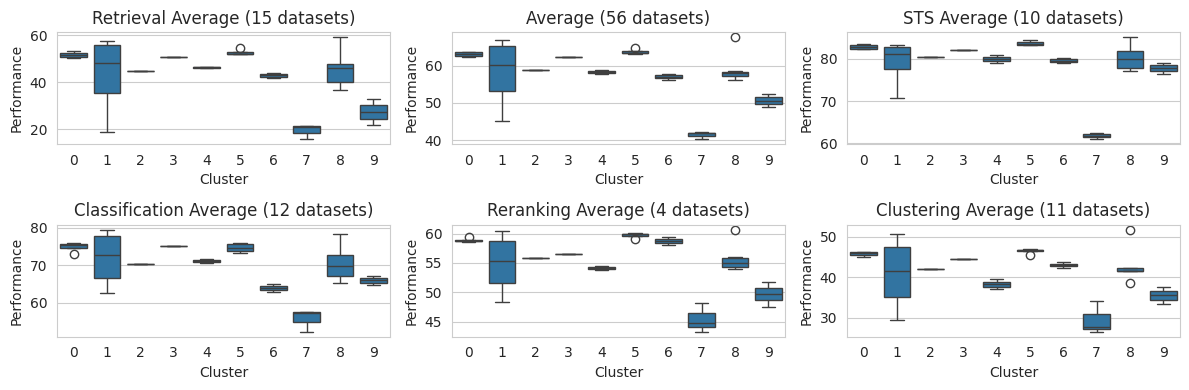

In [45]:

_METRICS = set(METRICS) - set(["I(X_1->X_2)/d_2"])
fig, ax = plt.subplots(figsize=(12, 4), ncols=3, nrows=(len(_METRICS) // 3), sharey=False)
ax = ax.flatten()

for i, metric in enumerate(_METRICS):
    ax[i] = sns.boxplot(data=cluster_mteb, x='community', y=metric, ax=ax[i])
    ax[i].set_title(metric)
    ax[i].set_xlabel('Cluster')
    ax[i].set_ylabel("Performance")
    fig.tight_layout()



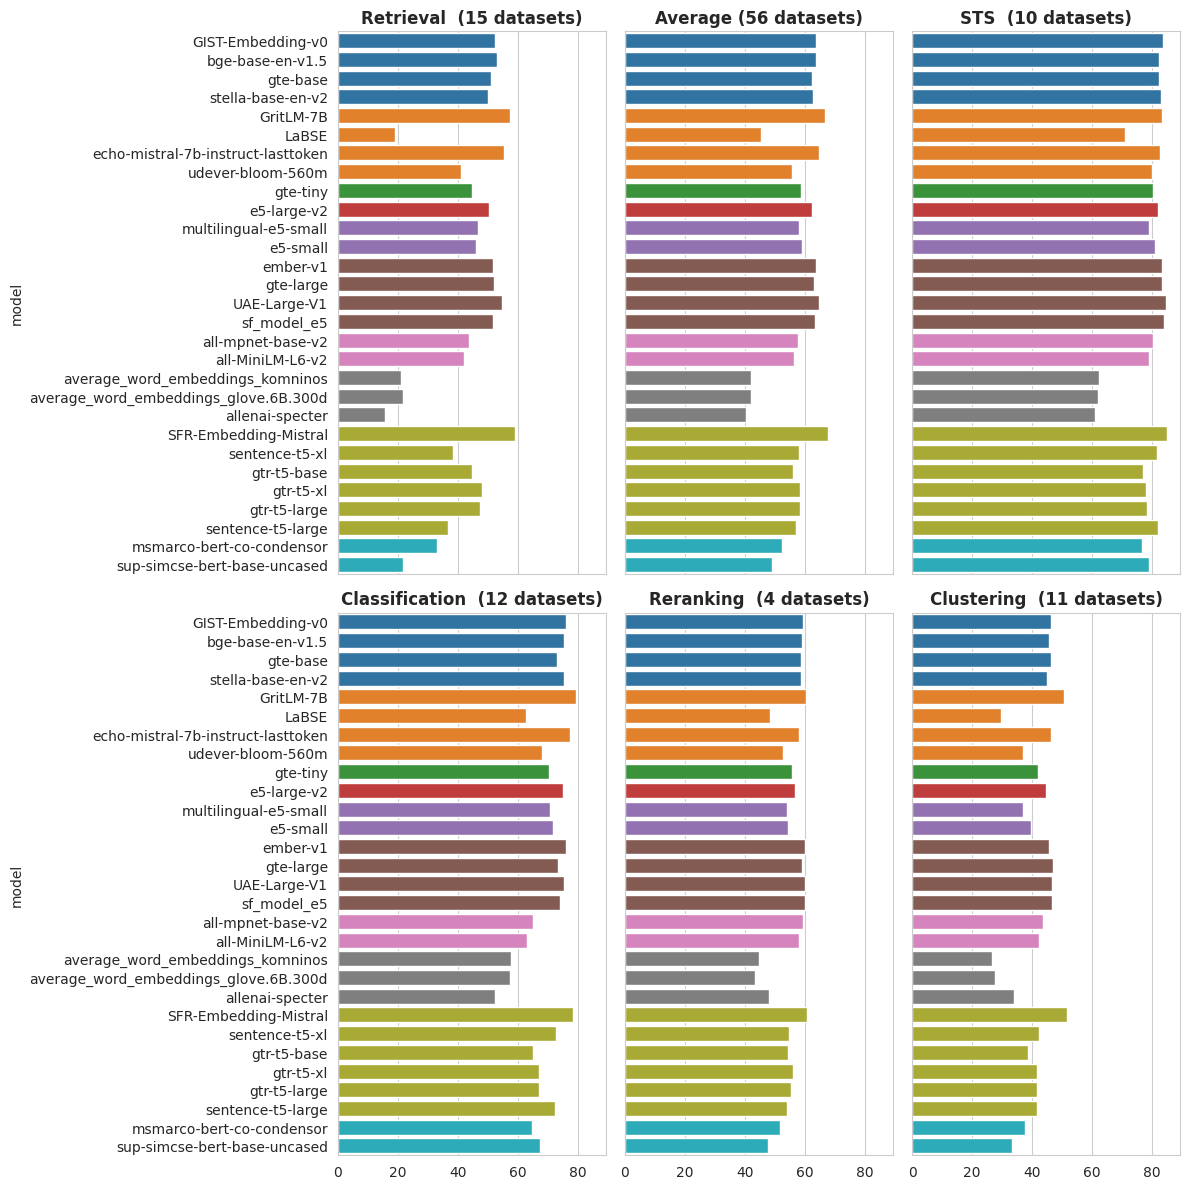

In [46]:


# make barplot group by community
_METRICS = set(METRICS) - set(["I(X_1->X_2)/d_2"])
fig, ax = plt.subplots(figsize=(12, 12), ncols=3, nrows=(len(_METRICS) // 3), sharey=True, sharex=True)
ax = ax.flatten()

hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

_df = cluster_mteb.copy()
# sort by communities
_df = _df.sort_values('community')
_df['community'] = _df['community'].astype(str)
for i, metric in enumerate(_METRICS):
    ax[i] = sns.barplot(data=_df, y='model', x=metric, ax=ax[i], hue='community', palette="tab10", legend=False, orient="h")
    
    
# rename x labels
for i, metric in enumerate(_METRICS):
    
    # make labels bigger
    if metric == "Average (56 datasets)":
        ax[i].set_title(metric, fontsize=12, fontweight='bold')
    else:
        ax[i].set_title(metric.replace('Average', ''), fontsize=12, fontweight='bold')
    ax[i].set_xlabel('')
    
    

# rotate x labels

fig.tight_layout()


path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_community_perfs_mtebs_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')


In [47]:
# Ranking per task and close models

In [48]:
# Select communities 

In [49]:
# select community of stella:  "stella-base-en-v2", "ember-v1", "jspringer/echo-mistral-7b-instruct-lasttoken"

selected_models = ["stella-base-en-v2", "ember-v1"]

communities = [node_to_community[model] for model in selected_models]

selected_models = cluster_mteb[cluster_mteb['community'].isin(communities)]['model'].unique()




,model,community,task,performance
2,stella-base-en-v2,0,Average (56 datasets),62.61
5,ember-v1,5,Average (56 datasets),63.54
6,gte-large,5,Average (56 datasets),63.13
7,UAE-Large-V1,5,Average (56 datasets),64.64
8,gte-base,0,Average (56 datasets),62.39
9,sf_model_e5,5,Average (56 datasets),63.34
10,GIST-Embedding-v0,0,Average (56 datasets),63.71
13,bge-base-en-v1.5,0,Average (56 datasets),63.55


,model,community,task,performance,rank
10,GIST-Embedding-v0,0,Average (56 datasets),63.71,1.0
13,bge-base-en-v1.5,0,Average (56 datasets),63.55,2.0
2,stella-base-en-v2,0,Average (56 datasets),62.61,3.0
8,gte-base,0,Average (56 datasets),62.39,4.0
7,UAE-Large-V1,5,Average (56 datasets),64.64,1.0
5,ember-v1,5,Average (56 datasets),63.54,2.0
9,sf_model_e5,5,Average (56 datasets),63.34,3.0
6,gte-large,5,Average (56 datasets),63.13,4.0


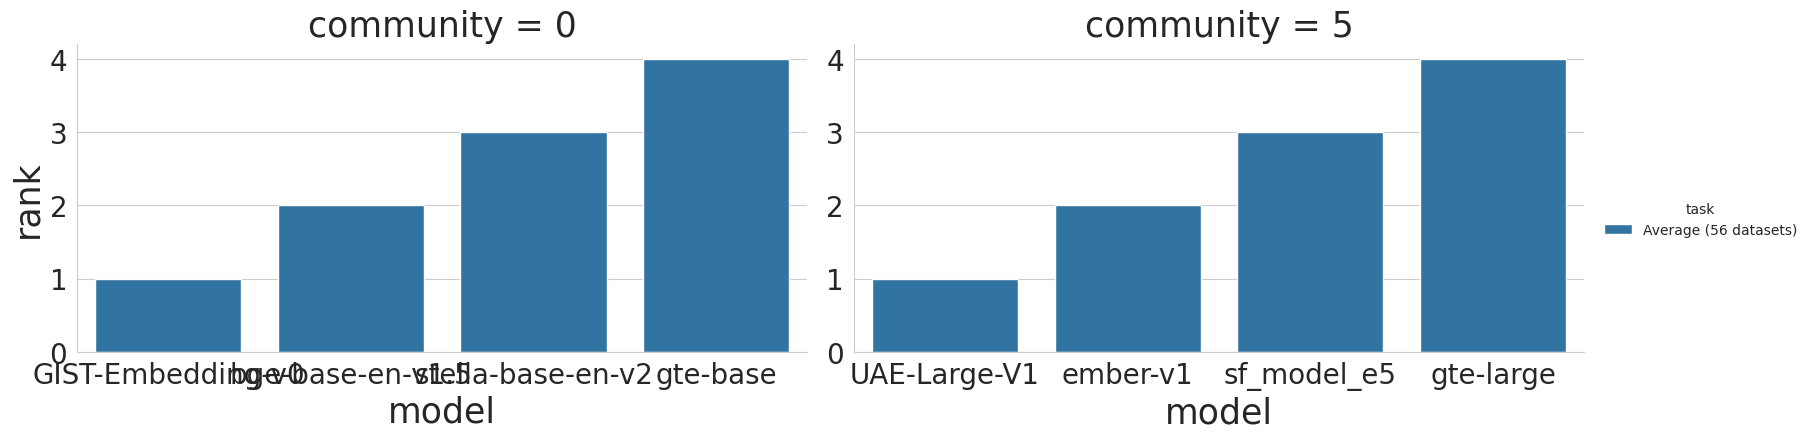

In [50]:

melted_clusters = cluster_mteb.melt(id_vars=['model', 'community'], var_name='task', value_name='performance')

# keep only Average (56 datasets) and I(X_1->X_2)/d_2
melted_clusters = melted_clusters[melted_clusters['task'].isin(['Average (56 datasets)', 'I(X_1->X_2)/d_2'])]

# keep only selected models
melted_clusters = melted_clusters[melted_clusters['model'].isin(selected_models)]

display(melted_clusters)

# make a meanranking per task
mean_ranking = melted_clusters.groupby(['task', 'community'])['performance'].rank(ascending=False)
melted_clusters['rank'] = mean_ranking
# rank by rank
melted_clusters = melted_clusters.sort_values(['task', 'community', 'rank'])

display(melted_clusters)

sns.catplot(data=melted_clusters, x='model', y='rank', hue='task', col='community', kind='bar', sharey=False, sharex=False, palette="tab10", height=4, aspect=2, orient='v')

# make font bigger

for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=25)
    ax.set_xlabel(ax.get_xlabel(), fontsize=25)
    ax.set_ylabel(ax.get_ylabel(), fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    # legend

